In [ ]:
#Instalación de paquetes necesarios
!sudo apt-get install jags
!pip install pyjags

Reading package lists... Done
Building dependency tree       
Reading state information... Done
jags is already the newest version (4.3.0-3bionic0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Paqueterias y clases

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV,ParameterSampler,KFold
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score,plot_roc_curve,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from tensorflow.random import set_seed
#from scikeras.wrappers import KerasClassifier
#import numpy as np
import pyjags
from pyjags.chain_utilities import  np
from random import seed
%matplotlib inline
plt.style.use('seaborn-deep')

In [ ]:
#Calse glm bayesiano

class bayesian_glm(object):

  def __init__(self,code,init=None,chains=4,n_iter=1000,thin=1,burn_iter=1000,**kargs):
    self.kargs=kargs
    self.params=['Beta']
    self.jags_code=code
    self.init=init
    self.chains=chains
    self.n_iter=n_iter
    self.thin=thin
    self.burn_iter=burn_iter

  def fit(self,X,y):
    self.X=X
    self.y=y
    self.n=len(self.y)
    self.n_params=self.X.shape[1]+1
    self.data={'y':self.y,'X':self.X,'n':self.n,'n_params':self.n_params}
    self.data.update(self.kargs)
    self.model=pyjags.Model(code=self.jags_code,
                            data=self.data,
                            init=self.init,chains=self.chains)
    self.model.sample(self.burn_iter,[],self.thin)
    self.samples=self.model.sample(self.n_iter,self.params,self.thin)
    self.weigths=[]

    for i in range(self.samples['Beta'].shape[0]):
      self.weigths.append(np.mean(self.samples['Beta'][i,:,:].flatten()))

    self.weigths=np.array(self.weigths)

  def predict_proba(self,X):

    X=np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    proba=1/(1+np.exp(-X.dot(self.weigths)))

    return proba

  def predict_class(self,X,threshold=0.5):

    probas=self.predict_proba(X)
    y_pred=np.where(probas>threshold,1,0)
    
    return y_pred

  def plot_trace_densities(self,params=[0],c='indigo',figsize=(10,5),hspace=0.4):
    fig,ax=plt.subplots(len(params),2)
    fig.set_figwidth(figsize[1])
    fig.set_figheight(figsize[0])
    fig.subplots_adjust(hspace=hspace)
    col=[]
    for j in range(self.chains):
      col.append('Chain {}'.format(j+1))
      k=0
    for i in params:
      pd.DataFrame(self.samples['Beta'][i,:,:],columns=col).plot(title='Trace',ax=ax[k,0],legend=False)

      pd.DataFrame(self.samples['Beta'][i,:,:].flatten()).plot(kind='density',
                                                               title='Density of Beta {}'.format(i),
                                                               ax=ax[k,1],
                                                               c=c,
                                                               legend=False)
      ax[k,1].set_ylabel('')
      k+=1

  def conf_matrix(self,X,y_true,threshold=0.5):
    y_pred=self.predict_class(X,threshold=threshold)
    conf_mat=pd.DataFrame(confusion_matrix(y_true,y_pred),columns=['False','True'],index=['False','True'])
    return conf_mat

  def compute_metrics(self,X,y_true,threshold=0.5,metric='accuracy'):

    conf_mat=self.conf_matrix(X,y_true,threshold).values

    TN=conf_mat[0,0]
    FP=conf_mat[0,1]
    FN=conf_mat[1,0]
    TP=conf_mat[1,1]

    accuracy=(TP+TN)/(TN+TP+FP+FN)
    fp_rate=FP/(FP+TN)
    specificity=1-fp_rate
    sensitivity=TP/(TP+FN)
    precision=TP/(TP+FP)
    f1_score=2*(sensitivity*precision)/(sensitivity+precision)

    if metric=='accuracy':
      return accuracy
    elif metric=='fp_rate':
      return fp_rate
    elif metric=='specificity':
      return specificity
    elif metric=='sensitivity':
      return sensitivity
    elif metric=='precision':
      return precision
    elif metric=='f1_score':
      return f1_score
    elif metric=='roc_auc_score':
      probas=self.predict_proba(X)
      return roc_auc_score(y_true,probas)
    
  def compute_cred_inter(self,alpha=0.05):
      cred_int=pd.DataFrame(np.zeros((self.n_params,4)),columns=['Parámetro','[{}'.format(alpha/2),'{}]'.format(1-alpha/2),'Sig.'])
      for i in range(self.n_params):
        cred_int.iloc[i,0]=['Beta {}'.format(i)]
        cred_int.iloc[i,[1,2]]=np.quantile(self.samples['Beta'][i,:,:].flatten(),[alpha/2,1-alpha/2])
        if cred_int.iloc[i,1]*cred_int.iloc[i,2]<0:
          cred_int.iloc[i,3]=False
        else:
          cred_int.iloc[i,3]=True
      return cred_int

  

class bayesian_logit_regression(bayesian_glm):
  __code = '''
            model{
              for (i in 1:n){
                y[i]~dbern(p[i])
                logit(p[i])=eta[i]
                eta[i]=Beta[1]+inprod(X[i,],Beta[2:n_params])
              }
              
              Beta~dmnorm(means,varcov)

            }
            '''
  def __init__(self,init=None,chains=4,n_iter=1000,thin=1,burn_iter=1000,means=None,varcov=None):
      super().__init__(self.__code,init,chains,n_iter,thin,burn_iter,means=means,varcov=varcov)


class bayesian_cloglog_regression(bayesian_glm):
  __code = '''
            model{
              for (i in 1:n){
                y[i]~dbern(p[i])
                cloglog(p[i])=eta[i]
                eta[i]=Beta[1]+inprod(X[i,],Beta[2:n_params])
              }
              
              Beta~dmnorm(means,varcov)

            }
            '''

  def __init__(self,init=None,chains=4,n_iter=1000,thin=1,burn_iter=1000,means=None,varcov=None):
      super().__init__(self.__code,init,chains,n_iter,thin,burn_iter,means=means,varcov=varcov)

class bayesian_probit_regression(bayesian_glm):
  __code='''
            model{
              for (i in 1:n){
                y[i]~dbern(p[i])
                p[i]=step(z[i])*0.99999999
                z[i]~dnorm(eta[i],1)
                eta[i]=Beta[1]+inprod(X[i,],Beta[2:n_params])
              }
              
              Beta~dmnorm(means,varcov)

            }
            '''

  def __init__(self,init=None,chains=4,n_iter=1000,thin=1,burn_iter=1000,means=None, varcov=None):
      super().__init__(self.__code,init,chains,n_iter,thin,burn_iter,means=means,varcov=varcov)


class bayesian_cauchit_regression(bayesian_glm):
  __code='''
            model{
              for (i in 1:n){
                y[i]~dbern(p[i])
                p[i]= (arctan(eta[i])/pi)+0.5
                eta[i]=Beta[1]+inprod(X[i,],Beta[2:n_params])
              }
              
              Beta~dmnorm(means,varcov)

            }
            '''

  def __init__(self,init=None,chains=4,n_iter=1000,thin=1,burn_iter=1000,means=None, varcov=None):
      super().__init__(self.__code,init,chains,n_iter,thin,burn_iter,means=means,varcov=varcov,pi=np.pi)

def cv_score(model,X,y,cv=10,threshold=0.5,metric='accuracy'):
  
  kf = KFold(n_splits=cv)
  train_metric=[]
  test_metric=[]

  for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train,y_train)
    train_metric.append(model.compute_metrics(X_train,y_train,threshold,metric))
    test_metric.append(model.compute_metrics(X_test,y_test,threshold,metric))

  return {'cv_train_metrics':np.array(train_metric),'cv_test_metrics':np.array(test_metric)}


# Preprocesamineto y análisis descriptivo de los datos 

In [ ]:
url='https://raw.githubusercontent.com/Yael313255748/datasets/main/heart.csv'
df=pd.read_csv(url)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
(df[df['HeartDisease']==0].describe()).iloc[:,[0,1,2,4,5]].round(3)

In [ ]:
(df[df['HeartDisease']==1].describe()).iloc[:,[0,1,2,4,5]].round(3)

In [ ]:
df.isna().sum()

In [ ]:
cat_col=df.columns[(df.dtypes==object)]
cat_col=cat_col.insert(0,'FastingBS')
cat_col=cat_col.insert(0,'HeartDisease')
cat_col

Index(['HeartDisease', 'FastingBS', 'Sex', 'ChestPainType', 'RestingECG',
       'ExerciseAngina', 'ST_Slope'],
      dtype='object')

In [ ]:
num_col=df.drop(cat_col,axis=1).columns
num_col

Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'], dtype='object')

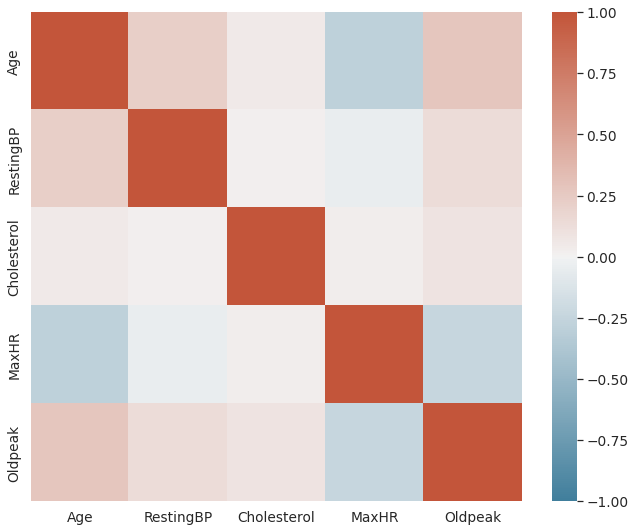

In [ ]:
sns.set(font_scale=1.25)
cor=df[num_col].corr()
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g=sns.heatmap(cor, cmap=cmap,vmin=-1,vmax=1)
#g.set_xticklabels()
plt.savefig('Correlograma.png',format='png',dpi=100)
#ax.set_xticklabels()
plt.show()


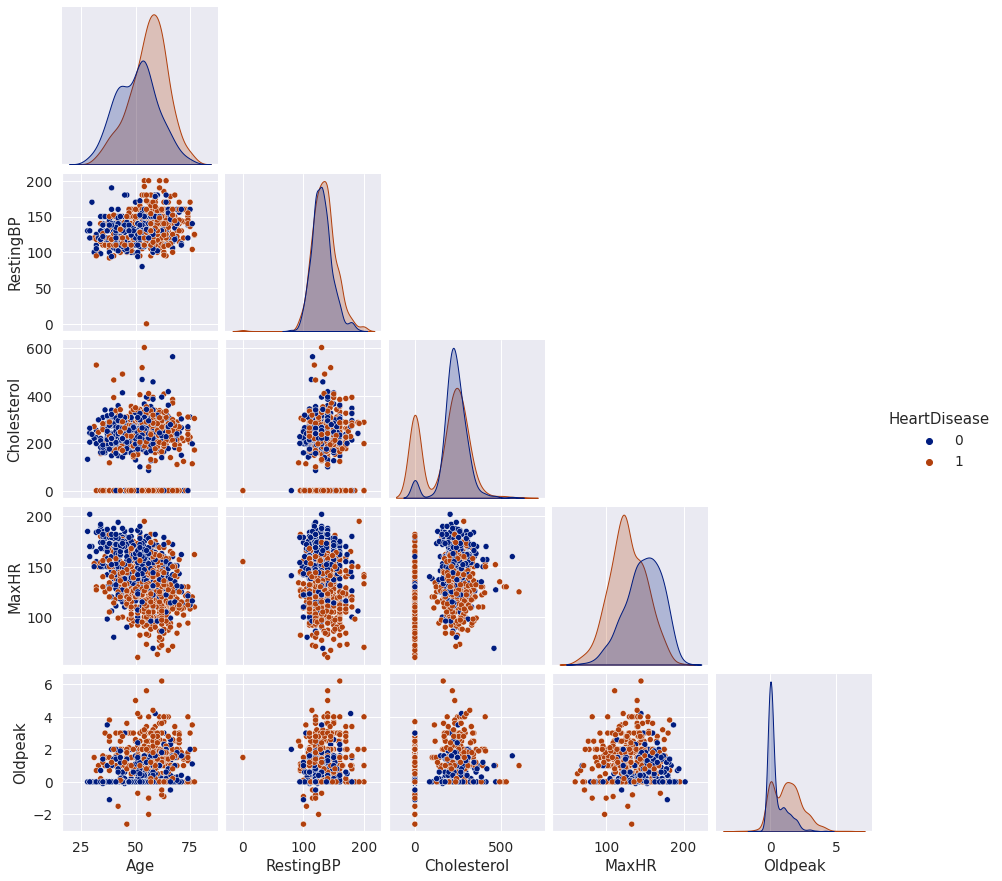

In [ ]:
sns.set(font_scale=1.25,palette='dark')
sns.set_style('darkgrid')
sns.pairplot(df[num_col.insert(0,'HeartDisease')],corner=True,hue='HeartDisease')
plt.savefig('pairplot.png',format='png',dpi=100)
plt.show()

In [ ]:
sns.set(font_scale=1.25,palette='dark')
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.4)
gs = plt.GridSpec(nrows=3, ncols=2)

ax11 = fig.add_subplot(gs[0, 0])

sns.boxplot(y='HeartDisease',x=num_col[0],data=df[[num_col[0],'HeartDisease']],
            hue='HeartDisease',palette="Set2",ax=ax11,linewidth=2.5,orient='h')
ax11.get_legend().remove()
ax11.set_xlabel(str(num_col[0]),fontdict={'weight': 'bold'})
ax11.set_ylabel('')

ax21 = fig.add_subplot(gs[0, 1])

sns.boxplot(y='HeartDisease',x=num_col[1],data=df[[num_col[1],'HeartDisease']],
            hue='HeartDisease',palette="Set2",ax=ax21,linewidth=2.5,orient='h')
ax21.get_legend().remove()
ax21.set_xlabel(str(num_col[1]),fontdict={'weight': 'bold'})
ax21.set_ylabel('')

ax31 = fig.add_subplot(gs[1, 0])

sns.boxplot(y='HeartDisease',x=num_col[2],data=df[[num_col[2],'HeartDisease']],
            hue='HeartDisease',palette="Set2",ax=ax31,linewidth=2.5,orient='h')
ax31.get_legend().remove()
ax31.set_xlabel(str(num_col[2]),fontdict={'weight': 'bold'})
ax31.set_ylabel('')

ax12 = fig.add_subplot(gs[1, 1])

sns.boxplot(y='HeartDisease',x=num_col[3],data=df[[num_col[3],'HeartDisease']],
            hue='HeartDisease',palette="Set2",ax=ax12,linewidth=2.5,orient='h')
ax12.get_legend().remove()
ax12.set_xlabel(str(num_col[3]),fontdict={'weight': 'bold'})
ax12.set_ylabel('')

ax22 = fig.add_subplot(gs[2:, :])

sns.boxplot(y='HeartDisease',x=num_col[4],data=df[[num_col[4],'HeartDisease']],
            hue='HeartDisease',palette="Set2",ax=ax22,linewidth=2.5,orient='h')
ax22.set_xlabel(str(num_col[4]),fontdict={'weight': 'bold'})
ax22.set_ylabel('')

handles, labels = ax22.get_legend_handles_labels()
ax22.get_legend().remove()

fig.legend(handles[0:2], ['Normal','Heart Disease'],loc='upper center',fontsize='large')
plt.savefig('boxplot1.png',format='png',dpi=100)
plt.show()

In [ ]:
j=0
datas=[]
for col in list(cat_col):
  if j==0:
    col=df.groupby([col]).count()
  else:
    col=df.groupby([col,cat_col[0]]).count()
  col=col.iloc[:,0]
  datas.append(col)
  #col=col/col.sum()
  j=j+1
sns.set(font_scale=1.5,palette='dark')
fig = plt.figure(figsize=(20,12))
gs = plt.GridSpec(nrows=3, ncols=3)
fig.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
ax7 = fig.add_subplot(gs[2, :])

Axes=[ax1,ax2,ax3,ax4,ax5,ax6,ax7]

for a,cc in zip(Axes,cat_col):
  g=sns.countplot(x=cc,hue=cat_col[0],data=df,ax=a)
  a.set_xlabel(cc,fontdict={'weight': 'bold'})
  a.get_legend().remove()
  a.set_ylabel('')
fig.legend(['Normal','Heart Disease'],loc='upper center',fontsize='large')
plt.savefig('barplot2.png',format='png',dpi=100)
plt.show()

In [ ]:
Q1=df[num_col].quantile(0.25)
Q3=df[num_col].quantile(0.75)
IQR=Q3-Q1
a=Q1-1.5*IQR
b=Q1+1.5*IQR
df_out=df[~ ((df <a) | (df>b)). any (axis = 1)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  


In [ ]:
df2=df_out.sample(df_out.shape[0],random_state=100)

In [ ]:
df2=pd.get_dummies(df2,columns=cat_col[2:],drop_first=True)
df2.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
120,47,135,248,1,170,0.0,1,0,0,1,0,1,0,0,1,0
680,57,150,276,0,112,0.6,1,1,0,0,0,0,0,1,1,0
542,54,138,274,0,105,1.5,1,0,0,0,0,1,0,1,1,0
851,53,138,234,0,160,0.0,0,0,0,0,0,0,0,0,0,1
561,54,132,182,0,141,0.1,0,1,1,0,0,0,1,0,0,1


In [ ]:
s=round(df2.shape[0]*0.8)
train=df2.iloc[:s,:]
test=df2.iloc[s:,:]

In [ ]:
print(train.shape)
print(test.shape)

(375, 16)
(94, 16)


In [ ]:
scaler=StandardScaler()
scaler.fit(train[num_col])
train[num_col]=scaler.transform(train[num_col])
test[num_col]=scaler.transform(test[num_col])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


<BarContainer object of 2 artists>

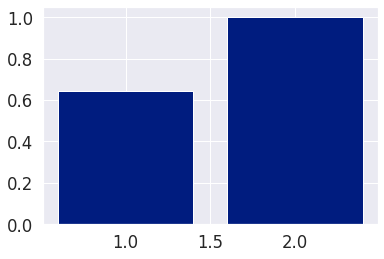

In [ ]:
pca=PCA()
pca.fit(train[['Age','MaxHR']])
plt.bar(np.arange(1,3,1), np.cumsum(pca.explained_variance_ratio_))

In [ ]:
pca_train=pca.transform(train[['Age','MaxHR']])
pca_test=pca.transform(test[['Age','MaxHR']])

In [ ]:
train[['PC1','PC2']]=pca_train[:,:2]
test[['PC1','PC2']]=pca_test[:,:2]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
train.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
120,-0.519711,0.541917,0.353733,1,1.441266,-0.859171,1,0,0,1,0,1,0,0,1,0
680,0.702180,1.730796,1.029780,0,-1.242828,-0.060025,1,1,0,0,0,0,0,1,1,0
542,0.335613,0.779693,0.981491,0,-1.566771,1.138695,1,0,0,0,0,1,0,1,1,0
851,0.213424,0.779693,0.015710,0,0.978491,-0.859171,0,0,0,0,0,0,0,0,0,1
561,0.335613,0.304142,-1.239805,0,0.099219,-0.725980,0,1,1,0,0,0,1,0,0,1


In [ ]:
X_train=train.drop(['HeartDisease']
                   ,axis=1).values
X_test=test.drop(['HeartDisease']
                 ,axis=1).values
y_train=train['HeartDisease'].values
y_test=test['HeartDisease'].values

# Ajuste de modelos

In [ ]:
k=X_train.shape[1]
varcov=np.zeros((k+1,k+1))
for i in range(varcov.shape[0]):
  varcov[i,i]=1/1000
means=np.repeat(0,k+1)
k
# varcov=np.zeros((6,6))
# for i in range(varcov.shape[0]):
#    varcov[i,i]=1/10000
#    means=np.repeat(0,6)

np.random.seed(10)

In [ ]:
np.random.seed(1089)
logit_model=bayesian_logit_regression(init=None,chains=3,n_iter=5000,burn_iter=2000,
                                      means=means,varcov=varcov,thin=5)
cv_logit_results=cv_score(logit_model,X_train,y_train,metric='roc_auc_score')
print('--------------------------------------------------------------\n')
loglog_model=bayesian_cloglog_regression(init=None,chains=3,n_iter=5000,burn_iter=2000,
                                      means=means,varcov=varcov,thin=5)
cv_loglog_results=cv_score(loglog_model,X_train,y_train,metric='roc_auc_score')
print('--------------------------------------------------------------\n')
probit_model=bayesian_probit_regression(init=None,chains=3,n_iter=5000,burn_iter=2000,
                                      means=means,varcov=varcov,thin=5)
cv_probit_results=cv_score(probit_model,X_train,y_train,metric='roc_auc_score')
print('--------------------------------------------------------------\n')

cauchit_model=bayesian_cauchit_regression(init=None,chains=3,n_iter=5000,burn_iter=2000,
                                      means=means,varcov=varcov,thin=5)
cv_cauchit_results=cv_score(cauchit_model,X_train,y_train,metric='roc_auc_score')
print('--------------------------------------------------------------\n')

adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 6000 of 6000, elapsed 0:00:04, remaining 0:00:00
sampling: iterations 7308 of 15000, elapsed 0:00:07, remaining 0:00:07
sampling: iterations 15000 of 15000, elapsed 0:00:14, remaining 0:00:00
sampling: iterations 15000 of 15000, elapsed 0:00:14, remaining 0:00:00
adapting: iterations 3000 of 3000, elapsed 0:00:02, remaining 0:00:00
sampling: iterations 4245 of 6000, elapsed 0:00:05, remaining 0:00:02
sampling: iterations 6000 of 6000, elapsed 0:00:06, remaining 0:00:00
sampling: iterations 15000 of 15000, elapsed 0:00:04, remaining 0:00:00
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 6000 of 6000, elapsed 0:00:02, remaining 0:00:00
sampling: iterations 15000 of 15000, elapsed 0:00:04, remaining 0:00:00
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 6000 of 6000, elapsed 0:00:02, remaining 0:00:00
sampling: i

In [ ]:
print('Test: \nmean: {:.4f}, std: {:.4f}\n'.format(cv_logit_results['cv_test_metrics'].mean(),cv_logit_results['cv_test_metrics'].std()))
print('Train:\nmean: {:.4f}, std: {:.4f}'.format(cv_logit_results['cv_train_metrics'].mean(),cv_logit_results['cv_train_metrics'].std()))

Test: 
mean: 0.9157, std: 0.0634

Train:
mean: 0.9351, std: 0.0053


In [ ]:
print('Test: \nmean: {:.4f}, std: {:.4f}\n'.format(cv_loglog_results['cv_test_metrics'].mean(),cv_loglog_results['cv_test_metrics'].std()))
print('Train:\nmean: {:.4f}, std: {:.4f}'.format(cv_loglog_results['cv_train_metrics'].mean(),cv_loglog_results['cv_train_metrics'].std()))

Test: 
mean: 0.9179, std: 0.0585

Train:
mean: 0.9336, std: 0.0048


In [ ]:
print('Test: \nmean: {:.4f}, std: {:.4f}\n'.format(cv_probit_results['cv_test_metrics'].mean(),cv_probit_results['cv_test_metrics'].std()))
print('Train:\nmean: {:.4f}, std: {:.4f}'.format(cv_probit_results['cv_train_metrics'].mean(),cv_probit_results['cv_train_metrics'].std()))

Test: 
mean: 0.9157, std: 0.0630

Train:
mean: 0.9353, std: 0.0054


In [ ]:
print('Test: \nmean: {:.4f}, std: {:.4f}\n'.format(cv_cauchit_results['cv_test_metrics'].mean(),cv_cauchit_results['cv_test_metrics'].std()))
print('Train:\nmean: {:.4f}, std: {:.4f}'.format(cv_cauchit_results['cv_train_metrics'].mean(),cv_cauchit_results['cv_train_metrics'].std()))

Test: 
mean: 0.9121, std: 0.0639

Train:
mean: 0.9322, std: 0.0058


# Mejor Modelo

In [ ]:
np.random.seed(1089)
best_model1=bayesian_logit_regression(init=None,chains=3,n_iter=5000,burn_iter=2000,
                                      means=means,varcov=varcov,thin=5)

best_model2=bayesian_probit_regression(init=None,chains=3,n_iter=5000,burn_iter=2000,
                                      means=means,varcov=varcov,thin=5)

best_model1.fit(X_train,y_train)
best_model2.fit(X_train,y_train)

adapting: iterations 3000 of 3000, elapsed 0:00:05, remaining 0:00:00
adapting: iterations 3000 of 3000, elapsed 0:00:05, remaining 0:00:00
sampling: iterations 5622 of 6000, elapsed 0:00:08, remaining 0:00:01
sampling: iterations 6000 of 6000, elapsed 0:00:09, remaining 0:00:00
sampling: iterations 6207 of 15000, elapsed 0:00:06, remaining 0:00:08
sampling: iterations 11400 of 15000, elapsed 0:00:12, remaining 0:00:04
sampling: iterations 15000 of 15000, elapsed 0:00:14, remaining 0:00:00
adapting: iterations 3000 of 3000, elapsed 0:00:03, remaining 0:00:00
sampling: iterations 6000 of 6000, elapsed 0:00:06, remaining 0:00:00
sampling: iterations 6000 of 6000, elapsed 0:00:06, remaining 0:00:00
sampling: iterations 7119 of 15000, elapsed 0:00:07, remaining 0:00:08
sampling: iterations 11919 of 15000, elapsed 0:00:14, remaining 0:00:04
sampling: iterations 15000 of 15000, elapsed 0:00:17, remaining 0:00:00


In [ ]:
Conf_int=best_model1.compute_cred_inter(0.5)
Conf_int

,Parámetro,[0.25,0.75],Sig.
0,Beta 0,-1.761649,-0.201366,True
1,Beta 1,-0.027485,0.232706,False
2,Beta 2,-0.150968,0.069332,False
3,Beta 3,0.314746,0.555090,True
4,Beta 4,0.125924,0.833510,True
5,Beta 5,-0.246480,0.012796,False
6,Beta 6,0.122812,0.403550,True
7,Beta 7,1.814222,2.467328,True
8,Beta 8,-2.852565,-2.160405,True
9,Beta 9,-1.985626,-1.379323,True


In [ ]:
best_model1.weigths.round(3)

array([-0.94 ,  0.106, -0.042,  0.433,  0.481, -0.114,  0.262,  2.141,
       -2.505, -1.683, -1.317,  0.253,  0.445,  1.056,  0.116, -2.418])

In [ ]:
thresholds=np.arange(0.1,1.0,0.1)
for alpha in thresholds:
  acc=best_model1.compute_metrics(X_test,y_test,threshold=alpha,metric='accuracy')
  speci = best_model1.compute_metrics(X_test,y_test,threshold=alpha,metric='specificity')
  senci = best_model1.compute_metrics(X_test,y_test,threshold=alpha,metric='sensitivity')
  print('threshold: {:.2f}, test_acc: {:.3f},test_speci: {:.3f}, test_senci: {:.3f}'.format(alpha,acc,speci,senci))

threshold: 0.10, test_acc: 0.862,test_speci: 0.780, test_senci: 0.955
threshold: 0.20, test_acc: 0.851,test_speci: 0.780, test_senci: 0.932
threshold: 0.30, test_acc: 0.851,test_speci: 0.840, test_senci: 0.864
threshold: 0.40, test_acc: 0.851,test_speci: 0.880, test_senci: 0.818
threshold: 0.50, test_acc: 0.862,test_speci: 0.920, test_senci: 0.795
threshold: 0.60, test_acc: 0.851,test_speci: 0.920, test_senci: 0.773
threshold: 0.70, test_acc: 0.798,test_speci: 0.920, test_senci: 0.659
threshold: 0.80, test_acc: 0.766,test_speci: 0.940, test_senci: 0.568
threshold: 0.90, test_acc: 0.681,test_speci: 1.000, test_senci: 0.318


In [ ]:
thresholds=np.arange(0.1,1.0,0.1)
for alpha in thresholds:
  acc=best_model2.compute_metrics(X_test,y_test,threshold=alpha,metric='accuracy')
  speci = best_model2.compute_metrics(X_test,y_test,threshold=alpha,metric='specificity')
  senci = best_model2.compute_metrics(X_test,y_test,threshold=alpha,metric='sensitivity')
  print('threshold: {:.2f}, test_acc: {:.3f},test_speci: {:.3f}, test_senci: {:.3f}'.format(alpha,acc,speci,senci))

threshold: 0.10, test_acc: 0.649,test_speci: 0.340, test_senci: 1.000
threshold: 0.20, test_acc: 0.819,test_speci: 0.700, test_senci: 0.955
threshold: 0.30, test_acc: 0.851,test_speci: 0.780, test_senci: 0.932
threshold: 0.40, test_acc: 0.872,test_speci: 0.880, test_senci: 0.864
threshold: 0.50, test_acc: 0.862,test_speci: 0.920, test_senci: 0.795
threshold: 0.60, test_acc: 0.798,test_speci: 0.920, test_senci: 0.659
threshold: 0.70, test_acc: 0.755,test_speci: 0.960, test_senci: 0.523
threshold: 0.80, test_acc: 0.628,test_speci: 1.000, test_senci: 0.205
threshold: 0.90, test_acc: 0.532,test_speci: 1.000, test_senci: 0.000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in long_scalars


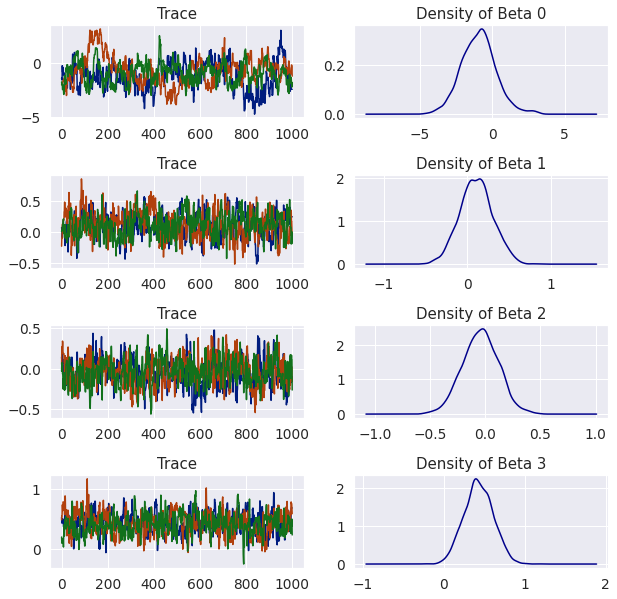

In [ ]:
best_model1.plot_trace_densities([0,1,2,3],figsize=(10,10),hspace=0.6,c='darkblue')

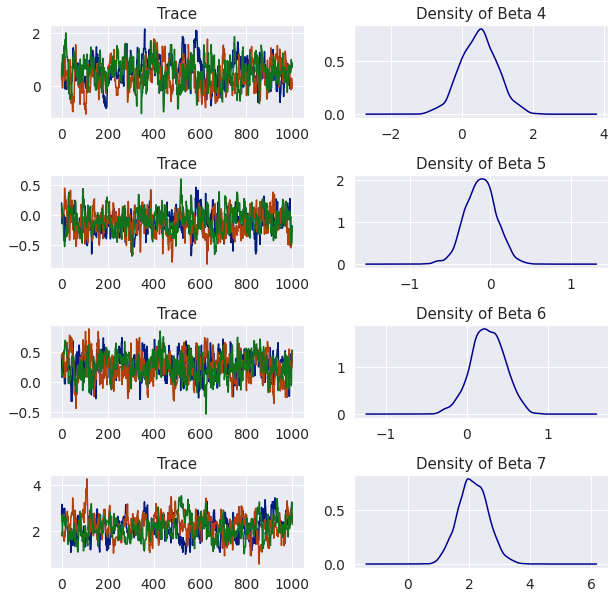

In [ ]:
best_model1.plot_trace_densities([4,5,6,7],figsize=(10,10),hspace=0.6,c='darkblue')

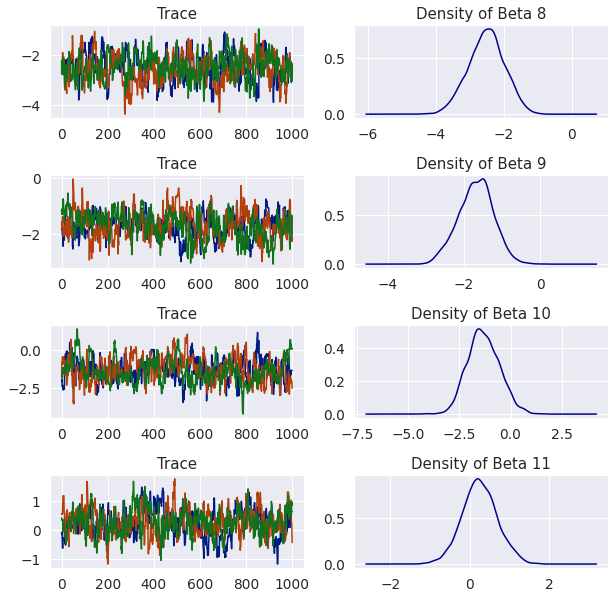

In [ ]:
best_model1.plot_trace_densities([8,9,10,11],figsize=(10,10),hspace=0.6,c='darkblue')

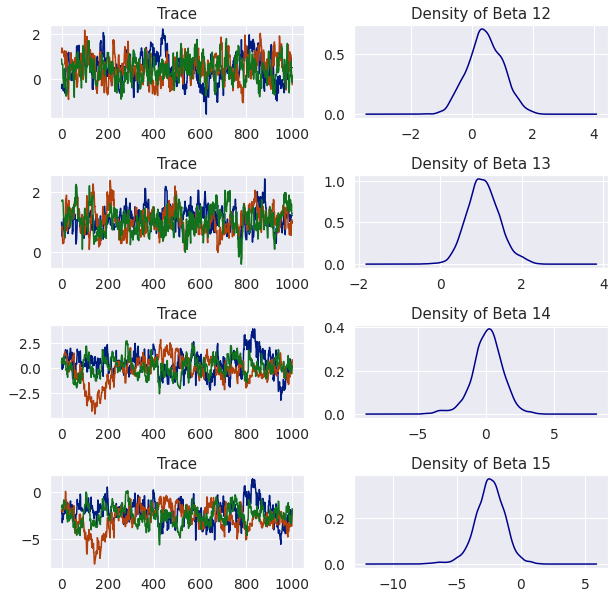

In [ ]:
best_model1.plot_trace_densities([12,13,14,15],figsize=(10,10),hspace=0.6,c='darkblue')

# Modelo con las variables significativas

In [ ]:
Conf_int[Conf_int['Sig.']==True]

,Parámetro,[0.025,0.975],Sig.
3,Beta 3,0.065385,0.811757,True
7,Beta 7,1.193707,2.985580,True
8,Beta 8,-3.623493,-1.525628,True
9,Beta 9,-2.571664,-0.807136,True
13,Beta 13,0.307996,1.779302,True
15,Beta 15,-4.519381,-0.466997,True


In [ ]:
x_sig=list(Conf_int[Conf_int['Sig.']==True].index-1)
X_sig=X_train[:,x_sig]

In [ ]:
X_train.shape

(375, 15)

In [ ]:
k=X_sig.shape[1]
varcov=np.zeros((k+1,k+1))
for i in range(varcov.shape[0]):
  varcov[i,i]=1/1000
means=np.repeat(0,k+1)
inits={'Beta':np.random.normal(size=k+1)}

In [ ]:
np.random.seed(356)
bestmodel2=bayesian_logit_regression(init=None,chains=3,n_iter=5000,burn_iter=2000,means=means,varcov=varcov,thin=5)
bestmodel2.fit(X_sig,y_train)

adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 6000 of 6000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 15000 of 15000, elapsed 0:00:02, remaining 0:00:00


In [ ]:
bestmodel2.compute_cred_inter()

,Parámetro,[0.025,0.975],Sig.
0,Beta 0,-1.669662,0.202314,False
1,Beta 1,0.078807,0.749237,True
2,Beta 2,1.323986,3.192546,True
3,Beta 3,-3.430184,-1.352745,True
4,Beta 4,-2.357407,-0.674807,True
5,Beta 5,0.564621,1.919686,True
6,Beta 6,-3.485731,-2.074980,True


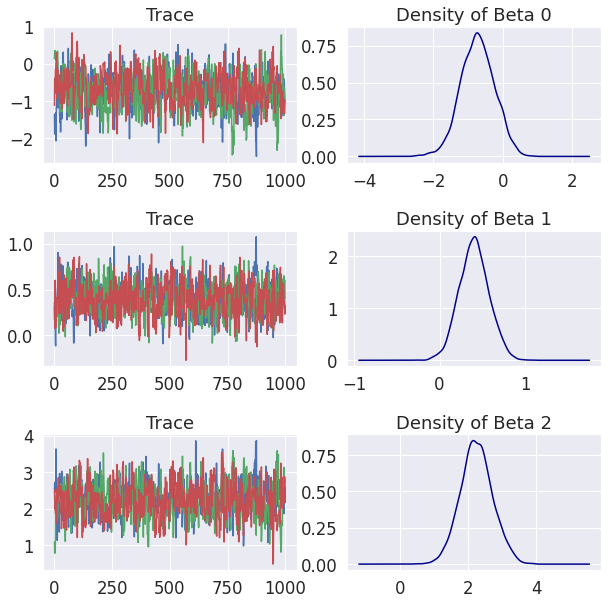

In [ ]:
bestmodel2.plot_trace_densities([0,1,2],figsize=(10,10),hspace=0.5,c='darkblue')

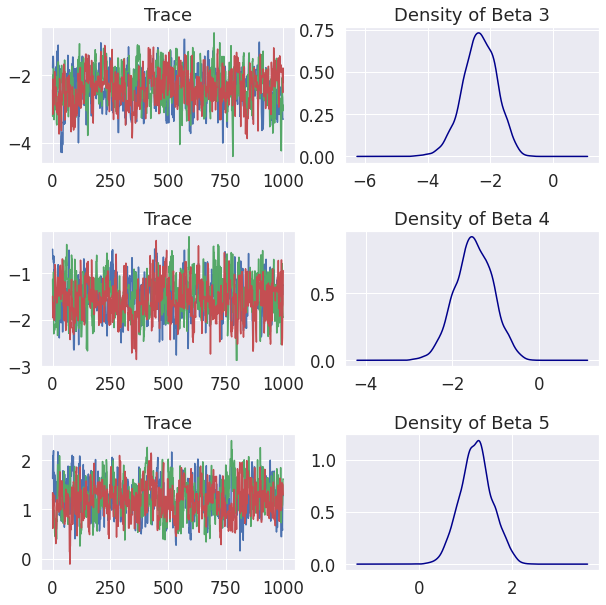

In [ ]:
bestmodel2.plot_trace_densities([3,4,5],figsize=(10,10),hspace=0.5,c='darkblue')

In [ ]:
thresholds=np.arange(0.1,1.0,0.1)
for alpha in thresholds:
  acc=bestmodel2.compute_metrics(X_test[:,x_sig],y_test,threshold=alpha,metric='accuracy')
  speci = bestmodel2.compute_metrics(X_test[:,x_sig],y_test,threshold=alpha,metric='specificity')
  senci = bestmodel2.compute_metrics(X_test[:,x_sig],y_test,threshold=alpha,metric='sensitivity')
  print('threshold: {:.2f}, test_acc: {:.3f},test_speci: {:.3f}, test_senci: {:.3f}'.format(alpha,acc,speci,senci))

threshold: 0.10, test_acc: 0.830,test_speci: 0.720, test_senci: 0.955
threshold: 0.20, test_acc: 0.851,test_speci: 0.780, test_senci: 0.932
threshold: 0.30, test_acc: 0.872,test_speci: 0.880, test_senci: 0.864
threshold: 0.40, test_acc: 0.851,test_speci: 0.880, test_senci: 0.818
threshold: 0.50, test_acc: 0.840,test_speci: 0.920, test_senci: 0.750
threshold: 0.60, test_acc: 0.830,test_speci: 0.940, test_senci: 0.705
threshold: 0.70, test_acc: 0.819,test_speci: 0.940, test_senci: 0.682
threshold: 0.80, test_acc: 0.755,test_speci: 0.960, test_senci: 0.523
threshold: 0.90, test_acc: 0.660,test_speci: 1.000, test_senci: 0.273
